In [18]:
import numpy as np
import corner
import h5py
import json
import sys
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q, chi_eff
import pycbc
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

import matplotlib.lines as mpllines
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
from pycbc.waveform import waveform
from pycbc.types.frequencyseries import FrequencySeries
from pycbc.conversions import mass1_from_mchirp_eta, mass2_from_mchirp_eta, mchirp_from_mass1_mass2, eta_from_mass1_mass2, q_from_mass1_mass2
from plotting_utils import pos_samples, plot_corner_2datasets, plot_corner_3datasets, title_formats
from pycbc.cosmology import redshift


In [19]:
inject_params = {'m1_det': 1.399899220066443,   #detector frame mass_1, taken from MAP values of (mass_1) GW170817 bilby samples
                 'm2_det': 1.3506923499131296,  #detector frame mass_2,taken from MAP values (mass_2) of GW170817 bilby samples 
                 'spin_1z':0.0001294116725339975, #spin_1z, taken from MAP values (spin_1z) of GW170817 bilby samples
                 'spin_2z':3.5461352589076355e-05, #spin_2z, taken from MAP values (spin_1z) of GW170817 bilby samples
                 'luminosity_distance': 40.4,   #taken from EM measurement of NGC 4993 (src:Hjorth et al. (2017))
                 'iota': 2.4975664366099606,    # taken from MAP value (iota) of GW170817 bilby samples
                 'ra': 3.44616, 'dec': -0.408084, #location of host galaxy NGC-4993
                 'pol':0}
                # 'tc': trigTime}

In [20]:
params = ['Mc', 'mass_ratio', 'chi1z', 'chi2z', 'chi_eff', 'iota', 'ra', 'dec', 'z', 'dL', 'Vcom', 'pol', 'tc']

In [21]:
#-- reading the samples from posterior file

with h5py.File('../post_samples/post_samples_interp_L1H1V1.hdf') as f:
    
    print(f.keys())
    
    #print(samples.keys())
    
    mchirp, q, chi_Eff = np.array(f['Mc']), np.array(f['mass_ratio']), np.array(f['chi_eff'])    
    iota, ra, dec = np.array(f['iota']), np.array(f['ra']), np.array(f['dec'])
    z, dL =  np.array(f['z']), np.array(f['dL'])
    
samps_rbf = np.column_stack((mchirp, q, chi_Eff, ra, dec, iota, dL, z))

<KeysViewHDF5 ['Mc', 'Vcom', 'chi1z', 'chi2z', 'chi_eff', 'dL', 'dec', 'iota', 'mass_ratio', 'pol', 'ra', 'tc', 'z']>


In [22]:
mchirp_center = mchirp_from_mass1_mass2(inject_params['m1_det'], inject_params['m2_det'])
mass_ratio_center = q_from_mass1_mass2(inject_params['m1_det'], inject_params['m2_det'])
chi_eff_center = chi_eff(inject_params['m1_det'], inject_params['m2_det'], inject_params['spin_1z'], inject_params['spin_2z'])
z_center = redshift(inject_params['luminosity_distance'])

In [23]:
truths = np.array([mchirp_center, mass_ratio_center, chi_eff_center, inject_params['ra'], inject_params['dec'], inject_params['iota'],\
                   inject_params['luminosity_distance'], z_center])

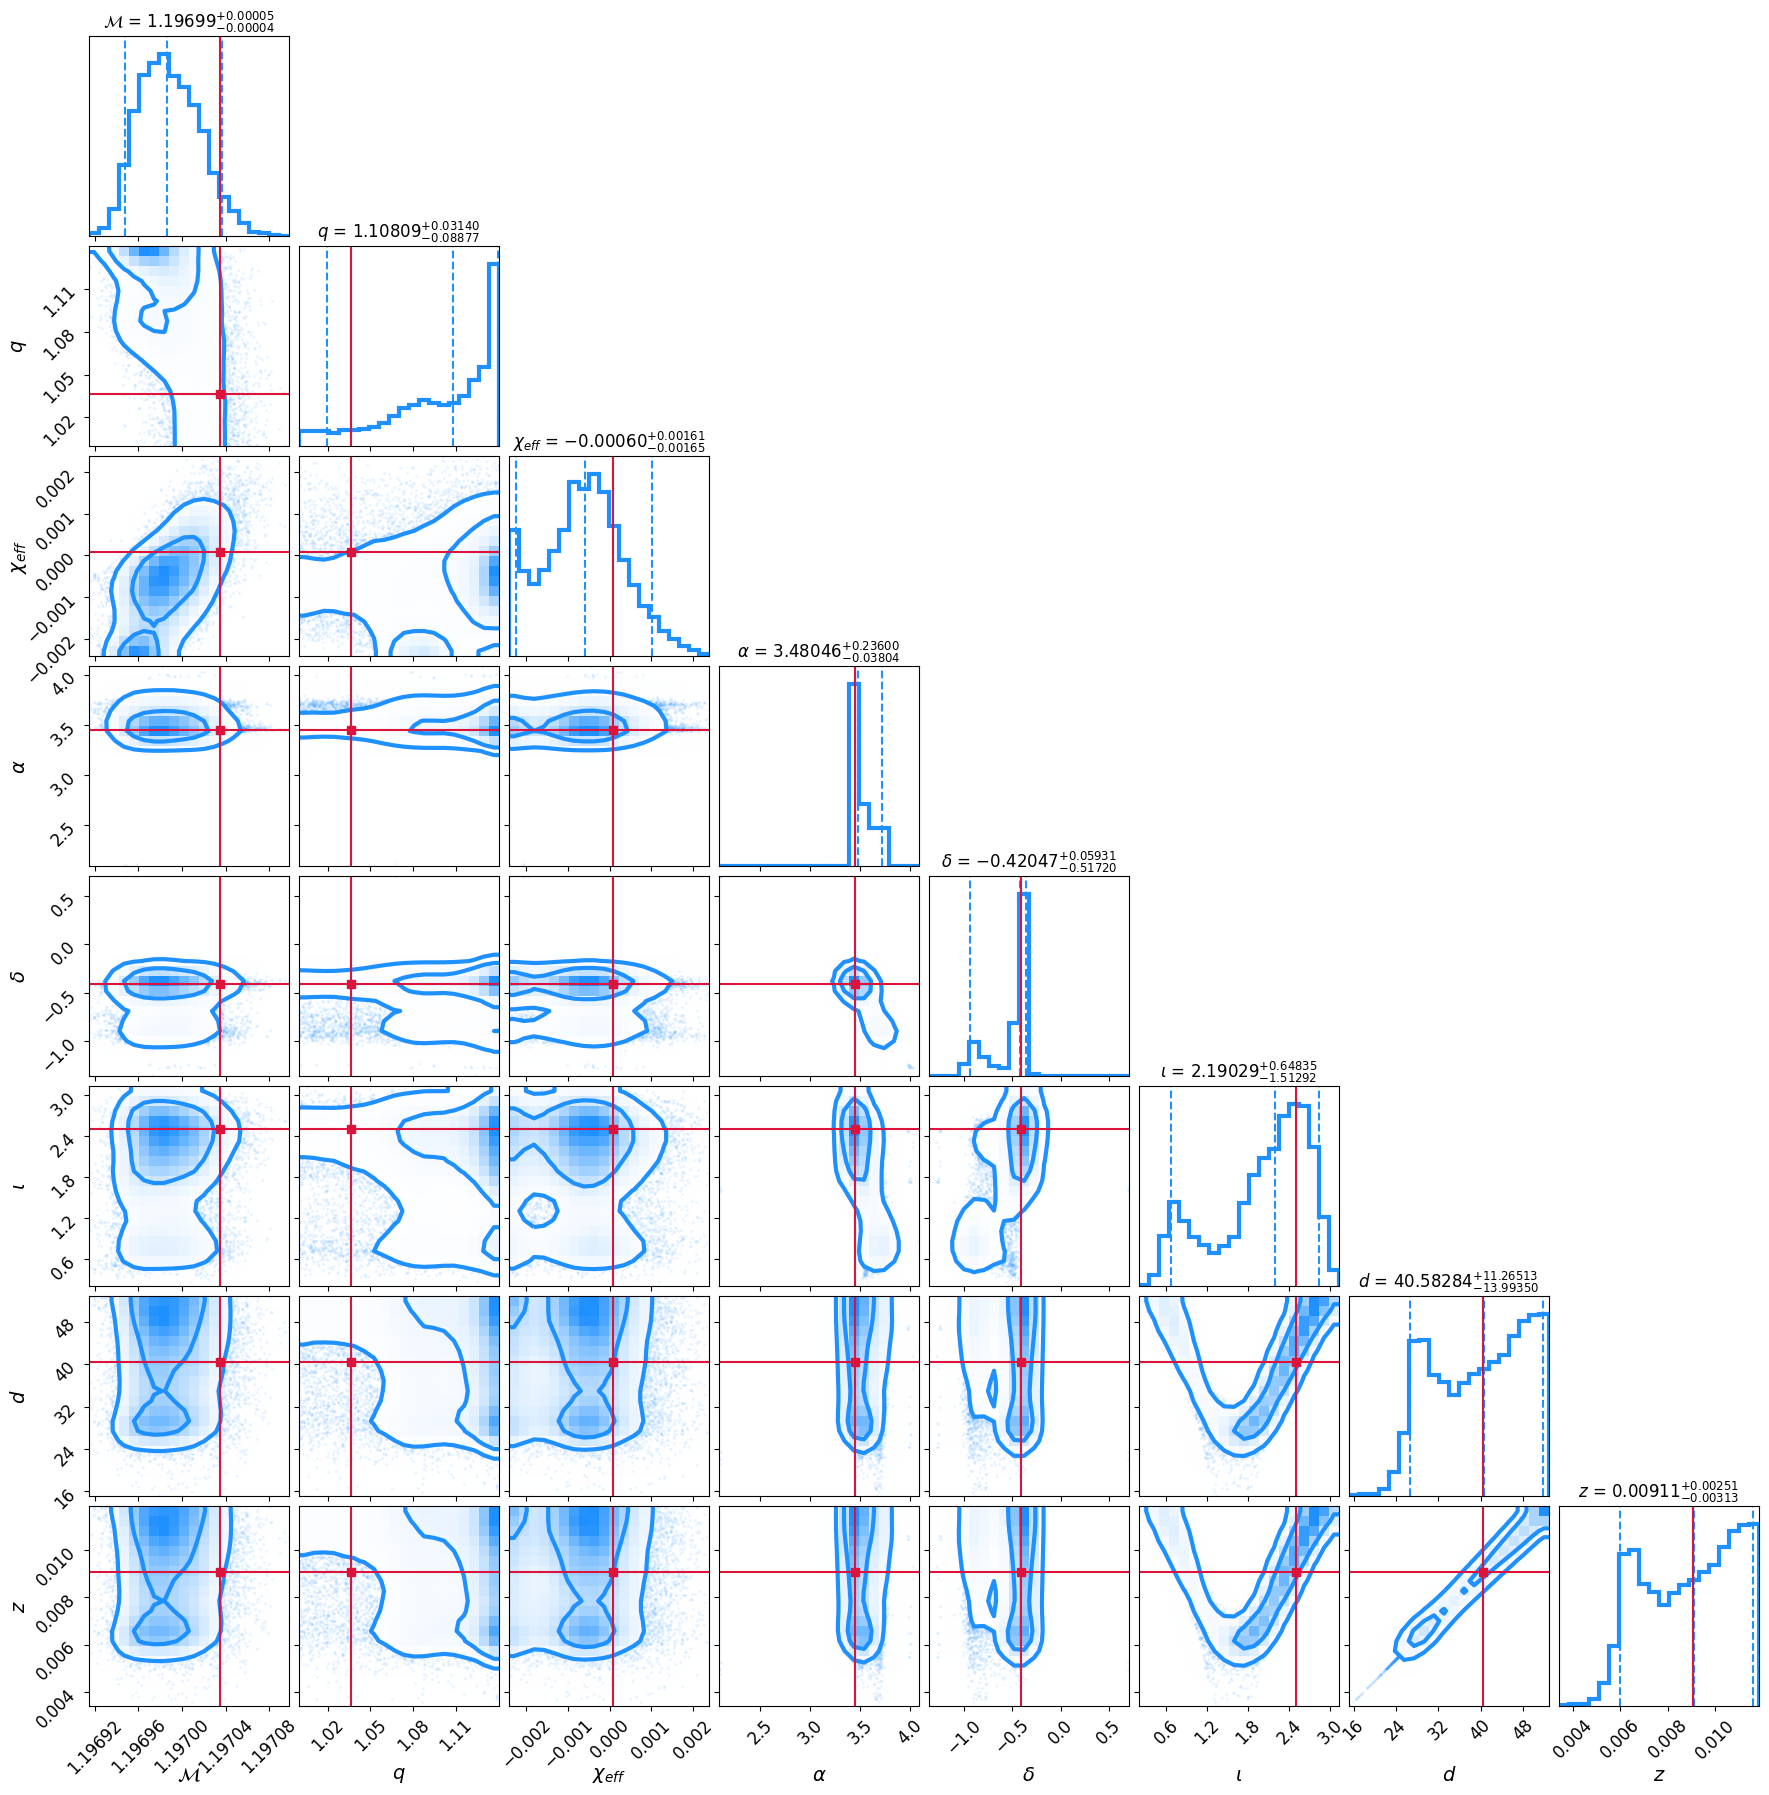

In [24]:
#-- corner plot --
fontsize = 14

labels = [r'$\mathcal{M}$', r'$q$', r'$\chi_{eff}$', r'$\alpha$', r'$\delta$', r'$\iota$', r'$d$', r'$z$']

fig = corner.corner(samps_rbf, truths=truths, color='dodgerblue', quantiles=[0.05, 0.5, 0.95], labels=labels, title_kwargs=dict(fontsize=fontsize-2), label_kwargs=dict(fontsize=fontsize), hist_kwargs=dict(lw=3), contour_kwargs=dict(linewidths=3), \
             truth_color='crimson', plot_datapoints=True, plot_density=True, show_titles=True, smooth=0.95, levels=[0.5, 0.9], title_fmt='.5f')

for ax in fig.get_axes():
    
    ax.tick_params(axis='both', labelsize=fontsize-2)
    
fig.show()

## Calculating the Error and relevent Statistics 

In [6]:

def calc_mode(samps, bins):
    
    """Function to calculate the mode
    
    Parameters
    -----------
    samps: samples
    bins: number of bins for np.histogram
    
    Returns
    --------
    map_val: mode/MAP value"""
    
    
    kernel = gaussian_kde(samps)
    count, val = np.histogram(samps, bins)
    val_pdf = kernel.pdf(val)
    map_val = val[np.argmax(val_pdf)]
    
    return map_val
